In [4]:
import ovrolwasolar as ols
from ovrolwasolar import utils as outils

data_update using version casarundata-2025.12.12-1.tar.gz, acquiring the lock ... 
Removing files using manifest from previous install of casarundata-2025.08.07-1.tar.gz on 2025-09-29
downloading casarundata contents to /home/pjzhang/.casa/data (336M) ... done
casarundata installed casarundata-2025.12.12-1.tar.gz at /home/pjzhang/.casa/data
measures_update ... acquiring the lock ... 
  ... finding available measures at www.astron.nl ...
  ... downloading WSRT_Measures_20260212-160001.ztar from ASTRON server to /home/pjzhang/.casa/data ...
  ... measures data updated at /home/pjzhang/.casa/data


In [5]:
fname  = '/home/pjzhang/dev/GRFFradioSun/script/pub/hdf/ovro-lwa-352.lev1.5_mfs_10s.2025-06-08T200703Z.image_I.hdf'

fits_out = 'ovro-lwa-352.lev1.5_mfs_10s.2025-06-08T200703Z.image_I.fits'
f_fits = outils.recover_fits_from_h5(fname, fits_out=fits_out)

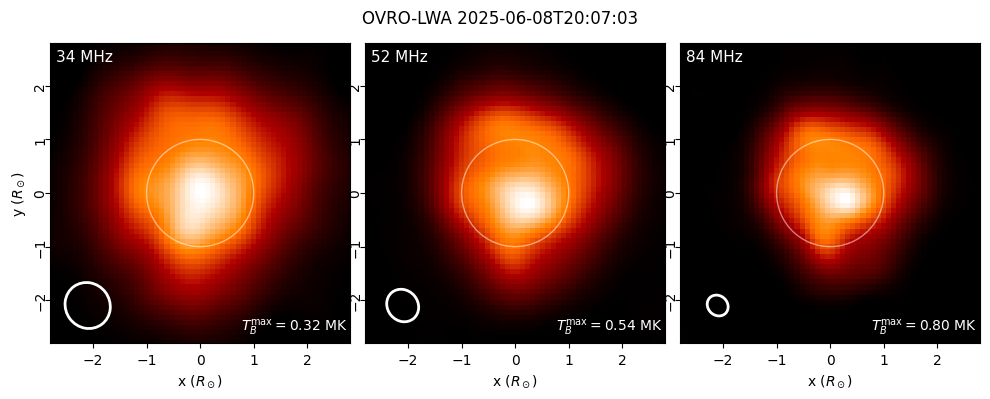

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from matplotlib import gridspec

# Load HDF (suncasa ndfits format)
from suncasa.io import ndfits
meta, rdata = ndfits.read(fits_out)

h = meta["header"]
cdelt1 = float(h["CDELT1"])   # arcsec/pix
cdelt2 = float(h["CDELT2"])
crpix1 = float(h["CRPIX1"])   # 1-based
crpix2 = float(h["CRPIX2"])
nx, ny = meta["nx"], meta["ny"]
# Extent: FITS pixel 0.5 at left edge, pixel nx-0.5 at right
left = (0.5 - crpix1) * cdelt1
right = (nx - 0.5 - crpix1) * cdelt1
bottom = (0.5 - crpix2) * cdelt2
top = (ny - 0.5 - crpix2) * cdelt2
extent = [left, right, bottom, top]

freqs_mhz = np.asarray(meta["ref_cfreqs"]) / 1e6
fov = 7998  # arcsec
inds = [0, 4, 11]
freqs_plt = [34.1, 38.7, 43.2, 47.8, 52.4, 57.0, 61.6, 66.2, 70.8, 75.4, 80.0, 84.5]
rsun_arcsec = float(h.get("RSUN_OBS", 945.0))  # solar angular radius (arcsec)
# Convert extent and limits to R_sun (1 arcsec = 1/rsun_arcsec R_sun)
extent_Rsun = [left / rsun_arcsec, right / rsun_arcsec, bottom / rsun_arcsec, top / rsun_arcsec]
fov_Rsun = fov / rsun_arcsec

fov_plot = 5.6

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 3, left=0.05, right=0.98, top=0.92, bottom=0.12, wspace=0.05)

for k, bd in enumerate(inds):
    ax = fig.add_subplot(gs[k])
    ax.set_facecolor("black")
    ax.set_xlabel("x ($R_\\odot$)")
    ax.set_ylabel("y ($R_\\odot$)")

    if bd < rdata.shape[1]:
        img = np.squeeze(rdata[0, bd, :, :] / 1e6)  # K -> MK
        vmaxplt = np.nanmax(img)
        if not np.isfinite(vmaxplt):
            vmaxplt = np.nanmax(img) if np.any(np.isfinite(img)) else 1.0

        ax.imshow(img, origin="lower", cmap="hinodexrt", vmin=0, vmax=vmaxplt, extent=extent_Rsun)

        # Solar limb (radius = 1 R_sun)
        ax.add_patch(Circle((0, 0), 1.0, fill=False, ls="-", color="w", alpha=0.5))
        # Beam ellipse (bmaj, bmin in deg -> arcsec -> R_sun)
        bmaj = meta["bmaj"][bd] * 3600 / rsun_arcsec
        bmin = meta["bmin"][bd] * 3600 / rsun_arcsec
        bpa = meta["bpa"][bd]
        beam = Ellipse((-fov_plot / 2 * 0.75, -fov_plot / 2 * 0.75), bmaj, bmin, angle=-(90 - bpa),
                       fc="none", lw=2, ec="w")
        ax.add_artist(beam)

        ax.text(0.02, 0.98, f"{freqs_plt[bd]:.0f} MHz", color="w", ha="left", va="top",
                fontsize=11, transform=ax.transAxes)
        ax.text(0.99, 0.02, r"$T_B^{\rm max}=$" + f"{vmaxplt:.2f} MK", color="w",
                ha="right", va="bottom", fontsize=10, transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, "No Data", color="w", ha="center", va="center",
                fontsize=18, transform=ax.transAxes)

    ax.set_xlim([-fov_plot / 2, fov_plot / 2])
    ax.set_ylim([-fov_plot / 2, fov_plot / 2])
    ax.set_aspect("equal")
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", va="center", rotation_mode="anchor")
    if k > 0:
        ax.set_ylabel("")

date_str = str(h.get("date-obs", h.get("DATE-OBS", "")))[:19]
fig.suptitle(f"OVRO-LWA {date_str}", fontsize=12)
plt.show()